# Data Collection


https://labrosa.ee.columbia.edu/millionsong/pages/getting-dataset#subset

What I wanted to do originally was pull everything out of this subset from the Million Song Dataset so this subset of the dataset was a collection of 10,000 random songs of the random 1 million from the larger set. Each song was an hdf5 file zipped up into tar.gz so I used an hdf5 getters script from tbertinmahieux on github: https://github.com/tbertinmahieux/MSongsDB/tree/master/PythonSrc to extract my needed information from the subset. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import glob
import datetime


The hdf5 getters script, which was used, but not included, consists of getter functions that would return specific parts of the hdf5 file. Rather than work through the entire data set to put the hdf5 entries together, I opted to use the script to extract the specific features I would eventually use and then combined those into a dataframe. 

In [ ]:
#I globbed the entire subset together in order to easily extract the features all at once
import glob
files = glob.glob('D:/Downloads/millionsongsubset_full.tar/millionsongsubset_full/MillionSongSubset/data/*/*/*/*.h5')
len(files)

In [ ]:
#made all of the features I needed to extract into a list
artist_name,danceability,duration,energy,key,loudness,mode,mode_confidence,tempo, time_signature, time_signature_confidence,title = ([] for i in range(12))

At this point, I was ready to make a dataframe of all the songs in the dataset. 

In [ ]:
for f in files:
    
    h5 = open_h5_file_read(f)
    #get all the necessary feature categories
    track_danceability = get_danceability(h5)
    track_key = get_key(h5)
    track_loudness = get_loudness(h5)
    ttempo = get_tempo(h5)
    time_sig = get_time_signature(h5)
    song_title = get_title(h5)
    track_energy = get_energy(h5)
    track_duration = get_duration(h5)
    name = get_artist_name(h5)
    track_mode = get_mode(h5)
    m_confidence = get_mode_confidence(h5)
    sig_confidence = get_time_signature_confidence(h5)
 
    
    danceability.append(track_danceability)
    key.append(track_key)
    loudness.append(track_loudness)
    tempo.append(ttempo)
    time_signature.append(time_sig)
    title.append(song_title)
    energy.append(track_energy)
    duration.append(track_duration)
    artist_name.append(name)
    mode.append(track_mode)
    mode_confidence.append(m_confidence)
    time_signature_confidence.append(sig_confidence)

    h5.close()

song_data = {'title':title,
             'danceability':danceability,
             'key':key,
             'loudness':loudness,
             'tempo':tempo,
             'time_signature':time_signature,
             'time_signature_confidence':time_signature_confidence,
             'energy':energy,
             'duration':duration,
             'artist_name':artist_name,
             'mode':mode,
             'mode_confidence':mode_confidence
            }
songs = pd.DataFrame(song_data)
songs.to_csv(r'C:\Users\Anna\Desktop\MSD_subset.csv')

In [14]:
songs = pd.read_csv(r'C:\Users\Anna\Desktop\MSD_subset.csv',index_col=0)

It was at this point, after the describe, that I found out the subset was lacking in a lot of the categories that I needed and I decided to use the subset as a list to search through and find the data for, which I knew was available on Spotify. This ended up being a lengthy two part process, in which I used Spotify's search with the song title and artist name to get the Spotify ID, then using the Spotify IDs to gather the audio features

In [15]:
#In order to actually use them in search, as you can see from above, there was cleaning necessarily on the strings to be able to use them.
df = songs.copy()
df['artist_name']=df['artist_name'].str[2:-1]
df['title']=df['title'].str[2:-1]

In [17]:
#made a separate dataframe where the only parts included are the artist name and title 
search_param = df[['artist_name','title']]

The Spotipy wrapper allows me to easily connect with the Spotify API, so here I import it, and in the manager, include the client ID and client secret which allows me to start up an instance of sp which allows me to begin querying the Spotify API. Then with the search string made, I can use "search" to return the track ID. 

In [ ]:
import spotipy
from __future__ import print_function    # (at top of module)
from spotipy.oauth2 import SpotifyClientCredentials
import json
import time
import sys
import pprint


client_credentials_manager = SpotifyClientCredentials(client_id='7c9c6c70bbcf4ab889e5dcdff781cc9e',client_secret=clientsecret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)


In [21]:
searchstrings = []
for i in range(10000):
    searchstrings.append('artist:'+search_param.iloc[i][0]+' track:'+search_param.iloc[i][1]) 
    #This takes my dataframe of artist and song names and combines them into one string in
    #the format that the Spotify API accepts to search

In [20]:
df.head()

,artist_name,danceability,duration,energy,key,loudness,mode,mode_confidence,tempo,time_signature,time_signature_confidence,title
0,Casual,0.0,218.93179,0.0,1,-11.197,0,0.636,92.198,4,0.778,I Didn't Mean To
1,The Box Tops,0.0,148.03546,0.0,6,-9.843,0,0.430,121.274,4,0.384,Soul Deep
2,Sonora Santanera,0.0,177.47546,0.0,8,-9.689,1,0.565,100.070,1,0.000,Amor De Cabaret
3,Adam Ant,0.0,233.40363,0.0,0,-9.013,1,0.749,119.293,4,0.000,Something Girls
4,Gob,0.0,209.60608,0.0,2,-4.501,1,0.371,129.738,4,0.562,Face the Ashes


In [ ]:
trackids = []
for x in range(10000):
    try:
        search_str = searchstrings[x]
        result = sp.search(search_str,limit=1)
        trackid = result['tracks']['items'][0]['uri']
        trackids.append(trackid)
    except IndexError: #included IndexError to deal with songs that were not in the Spotify API, skipped and moved to next song
        pass
    

This gave me a list of trackids. When I finished, I realized that the total was not enough, since some of the song title/artist name combinations were not in the Spotify API, so I imported one more bit of the big set, and set out to get the track ids once more, as shown below. Now that I know exactly what I need, I no longer need to include all the extra features and can just query for specific features, in this case, just the title and artist name.

In [ ]:
import glob
files = glob.glob('F:/MSD/A.tar/*/*/*/*.h5') #get more of the rest of the dataset 

title = []
artist_name=[]
for f in files:
    h5 = open_h5_file_read(f)
    song_title = get_title(h5)
    name = get_artist_name(h5)
    title.append(song_title)
    artist_name.append(name)
    h5.close()
song_data = {'title':title,'artist_name':artist_name}
songs = pd.DataFrame(song_data)


In [ ]:
songs = pd.read_csv(r'C:\Users\Anna\Desktop\MSD_subset2.csv',index_col=0)
df = songs.copy()
df['artist_name']=df['artist_name'].str[2:-1]
df['title']=df['title'].str[2:-1]
#cleaning it one more time for search. 

I then compiled them all together into one massive track id list. At which point I went back into the spotify API and pulled features for all of the track IDs.

In [ ]:
trackid = pd.read_csv(r'C:\Users\Anna\Desktop\Tracks.csv') 
tids = trackid['Track Ids'].tolist()

df=pd.DataFrame()
for i in range(0,29239,100):
    tids = trackid[i:i+100] #Spotify sound accepts 100 inputs at a time for audio features, so I break it up here
    start = time.time()
    features = sp.audio_features(tids) #instead of using Spotify search, we use Spotify Web to get audio features
    delta = time.time() - start
    data = []
    for feature in features:
        data.append(feature)
    if i==0:
        df = pd.DataFrame(data)#initializes the dataframe so it doesnt throw an error when I start
    else:
        df2 = pd.DataFrame(data)
        df= df.append(df2)#add each batch to the dataframe 

With some additional cleaning up to the dataframes because I had to do multiple batches due to hardware limitations, I ended up with a dataframe of all of the audio features from the songs that were in the subset and first part of the dataset. 

In [ ]:
df=pd.read_csv(r'C:\Users\Anna\Desktop\MSD_firstset.csv')
print(df.shape)
df.head()

# Data Cleaning & EDA

The problem is at this point I realized that the only identifying feature in this dataframe was the spotify track ID, so in return I decided to make a dictionary of track IDs with tracks as keys and song title as values. 

In [ ]:
#making my dictionary of names, artists, and track IDs 
names = []
artists = []
for i in range(0,len(tids),50):
    trackids = tids[i:i+50]
    result = sp.tracks(trackids) #grab the name and artist from the Spotify track ID
    for each in range(len(trackids)):
        name = result['tracks'][each]['name']
        artist = result['tracks'][each]['artists'][0]['name']
        names.append(name)
        artists.append(artist)

huh = {'id':tids,'Name':names,'Artist':artists}
track_dict = pd.DataFrame(huh)
#this is the dictionary

what = pd.DataFrame([tids,names])
what= what.T
what.columns=['track','name'] 
#and this is a dataframe of that dictionary

At this point I realized that there were duplicates in the subset and the dataset and that needed to be checked and removed so I did so below. 

In [ ]:
#below is how I figured out the duplicates
pd.concat(g for _, g in what.groupby('track') if len(g) > 1)

In [ ]:
#then I decided to drop duplicates cross checking with the above list 
df2=pd.read_csv(r'C:\Users\Anna\Desktop\track_dict.csv',index_col=0)
df2= df2.drop_duplicates()
print(df2.shape)
df2.head()

In [ ]:
df1= pd.merge(df, df2, on='id') #merging the track dictionary into the original dataframe with the audio features

In [ ]:
#dropped entirely useless features that would not be used in analysis
df1=df1.drop(['analysis_url','track_href','type','uri'],axis=1)

In [ ]:
df1.dtypes

In [ ]:
df1.to_csv(r'C:\Users\Anna\Desktop\MSD_finalfirstset.csv',index=False)

In [2]:
df= pd.read_csv(r'C:\Users\Anna\Desktop\MSD_finalfirstset.csv')

In [3]:
df.head()

,acousticness,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,Artist,Name
0,0.063000,0.751,218933,0.549,01TR6aAKrA2cI3Z0gnCOsu,0.000025,6,0.1060,-10.508,0.0,0.4290,92.224,4,0.553,Casual,I Didn't Mean To
1,0.195000,0.749,147760,0.530,4yPl1mK1oluIrCwI4HInPR,0.000035,9,0.0748,-12.940,1.0,0.0326,121.395,4,0.966,The Box Tops,Soul Deep
2,0.689000,0.699,183027,0.519,5JeyXbf7CrVQ8DqwFikN0P,0.000471,8,0.9350,-6.422,1.0,0.0290,102.463,4,0.676,La Sonora Santanera,Amor de Cabaret (with Río Roma)
3,0.197000,0.596,232107,0.934,1BddSZ9x0Vi2WfZOSna47Z,0.007410,0,0.1840,-3.812,1.0,0.0459,120.055,4,0.843,Adam Ant,Something Girls
4,0.000356,0.525,209600,0.918,4cdbM6efK43Cs2PDMtzdhv,0.566000,2,0.0904,-4.512,1.0,0.0543,129.727,4,0.655,Gob,Face the Ashes


I tried to see if I could visually assess what was happening in the dataset. For instance below I tried to plot the average decibel level of each song. However, with a dataset of nearly 14000, I realized quickly that this wouldn't be the best way to do it, and instead used describes. 

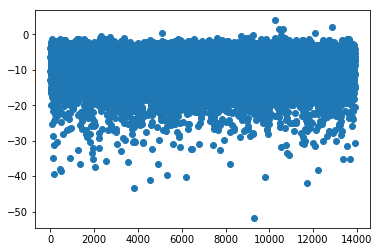

In [4]:
plt.scatter(df.index,df.loudness)

In [5]:
df.loudness.describe()

count    13908.000000
mean        -9.597650
std          4.855594
min        -51.770000
25%        -12.053250
50%         -8.602000
75%         -6.129500
max          3.924000
Name: loudness, dtype: float64

I wanted to normalize all of the continuous variables in order to make sure inertia when I was doing clustering would have them all in the same degree of magnitude. That necessitated me putting all continuous numeric variables between 0 and 1. 

In [6]:
#Normalizing all continuous values to be between 0 and 1
new_loudness = []
maxi = df.loudness.max()
mini = df.loudness.min()
for row in range(len(df.index)):
    new= (df.loudness[row]-mini)/(maxi-mini)
    new_loudness.append(new)
df['loudness']=new_loudness

new_tempo = []
maxi = df.tempo.max()
mini = df.tempo.min()
for row in range(len(df.index)):
    new= (df.tempo[row]-mini)/(maxi-mini)
    new_tempo.append(new)
df['tempo']=new_tempo

new_duration = []
maxi = df.duration_ms.max()
mini = df.duration_ms.min()
for row in range(len(df.index)):
    new= (df.duration_ms[row]-mini)/(maxi-mini)
    new_duration.append(new)
df['duration_ms']=new_duration

df.describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
count,13908.000000,13908.000000,13908.000000,13908.000000,13908.000000,13908.000000,13908.000000,13908.000000,13908.000000,13908.000000,13908.000000,13908.000000,13908.000000
mean,0.309816,0.543034,0.082977,0.617690,0.213626,5.298461,0.216449,0.757215,0.682485,0.088722,0.489985,3.887619,0.512493
std,0.339050,0.182462,0.040489,0.258185,0.339677,3.535764,0.195472,0.087183,0.465526,0.117046,0.121250,0.456282,0.265878
min,0.000000,0.000000,0.000000,0.000020,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.009567,0.416000,0.060767,0.426000,0.000002,2.000000,0.095175,0.713124,0.000000,0.035200,0.398124,4.000000,0.299000
50%,0.148000,0.555000,0.076746,0.652000,0.001160,5.000000,0.133000,0.775092,1.000000,0.048200,0.487824,4.000000,0.516000
75%,0.609000,0.680000,0.096615,0.842000,0.373000,9.000000,0.280000,0.819487,1.000000,0.084100,0.561290,4.000000,0.734000
max,0.996000,0.984000,1.000000,1.000000,0.997000,11.000000,0.997000,1.000000,1.000000,0.963000,1.000000,5.000000,1.000000


I also attempted to see the spread of the dataset features as a whole, which I used histogram for but I realized very quickly that this wasn't the best way to do it. Therefore, I decided to go with boxplots to try to see if anything in the dataset had extremely large outliers based on the boxplot but it seems that in the large dataset, there weren't any vast outliers that would skew the model. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000257415588D0>,
      dtype=object)

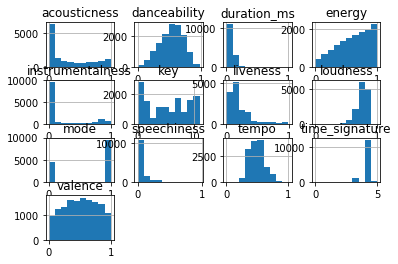

In [7]:
df.hist()

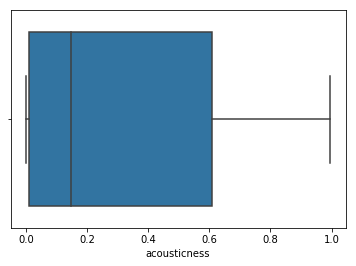

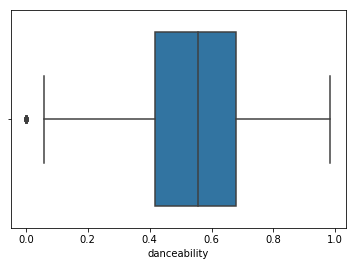

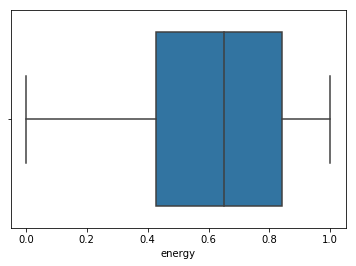

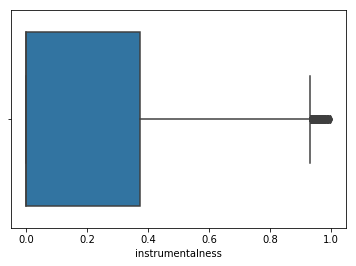

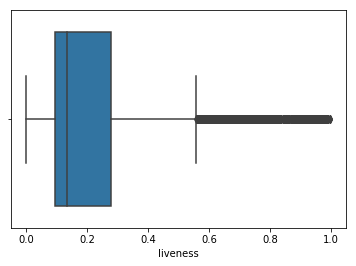

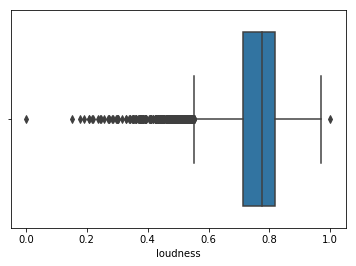

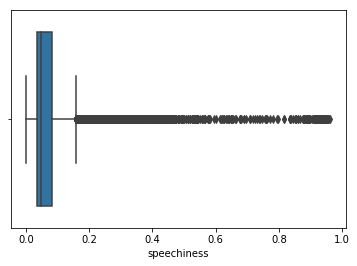

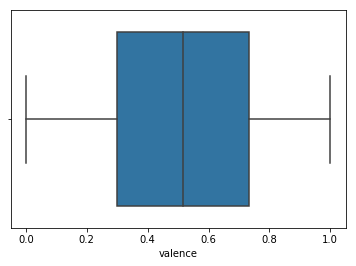

In [10]:
features = ['acousticness','danceability','energy','instrumentalness','liveness','loudness','speechiness','valence']

for each in features:
    sns.boxplot(df[each]) #used this to check for outliers, but most of the dataset fell within a reasonable amount of the IQR
    plt.show();

Speechiness seemed to have the largest issue with not being groupable. However, I believed it was best to leave those as to be able to cluster spoken word pieces together with others rather than only using what is traditionally believed to be songs. Since those high on the speechiness were more likely spoken only pieces, including them was important as to not introduce bias to songs that were traditionally "music". 

# Building a Model 

The thing I tried to do first was KPrototypes Clustering. This is similar to KMeans except it could take both categorical and numerical data, so it seemed a good fit for my data. 

In [ ]:
from kmodes.kprototypes import KPrototypes

kproto = KPrototypes(n_clusters=4)
kproto.fit(df[['acousticness','danceability','energy','instrumentalness','liveness','speechiness','valence','key','mode','time_signature']],categorical=[7,8,9])
df.loc[:,'labels'] = kproto.labels_
print(kproto.cluster_centroids_)

In addition I attempted to apply the elbow method to find out the optimal number of clusters to use. 

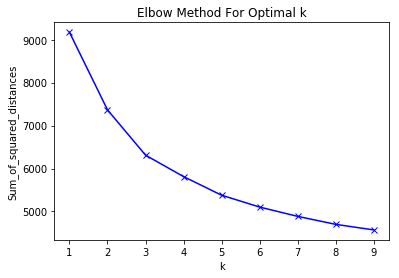

In [12]:
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    kp = KPrototypes(n_clusters=k)
    kp = kp.fit(df[['acousticness','danceability','energy','instrumentalness','liveness','speechiness','valence','key','mode','time_signature']],categorical=[7,8,9])
    Sum_of_squared_distances.append(kp.cost_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [15]:
start_time = time.time()
kproto = KPrototypes(n_clusters=80,init='random')
kproto.fit(df[['acousticness','danceability','duration_ms','energy','instrumentalness','liveness','speechiness','valence','key','mode','time_signature']],categorical=[8,9,10])
df.loc[:,'labels'] = kproto.labels_

[array([[1.31068562e-01, 4.60854167e-01, 9.28678745e-02, 5.09208474e-01,
        4.85602942e-02, 1.47150000e-01, 4.28812500e-02, 2.64772222e-01],
       [7.46544118e-01, 5.84397059e-01, 8.81557989e-02, 4.37494853e-01,
        7.97345588e-01, 1.46988971e-01, 6.07286765e-02, 5.25230147e-01],
       [6.57272727e-01, 5.01103896e-01, 8.86821535e-02, 4.92662338e-01,
        2.79341260e-02, 7.55597403e-01, 1.28802597e-01, 4.88971429e-01],
       [2.04333528e-02, 4.34004825e-01, 1.00290277e-01, 8.66868421e-01,
        7.70469298e-01, 2.16444298e-01, 9.06149123e-02, 2.25968421e-01],
       [8.84246981e-02, 6.52590604e-01, 8.33566914e-02, 8.35610738e-01,
        3.04775581e-02, 1.66595302e-01, 7.76604027e-02, 7.85872483e-01],
       [4.97006312e-02, 3.42545455e-01, 8.10884328e-02, 8.93792208e-01,
        5.00139318e-02, 6.73389610e-01, 1.47288312e-01, 2.42909091e-01],
       [4.40511846e-02, 4.17047244e-01, 7.80192530e-02, 8.29350394e-01,
        2.94951191e-02, 2.33389370e-01, 9.26874016e-02, 4

Then I realized I needed to take a step back and think about it from the big picture perspective rather than the data science perspective. The clusters would be of songs, and would naturally form themselves into groups. The cluster size should have been close to how large I wanted each recommendation set to be, rather than the optimal based on smallest distance.

There however was a hiccup to this plan when my own hardware became a limiting factor and I was forced to limit the clustering based on the largest one my computer would handle. However, these clusters were still too large, and my first idea was to cluster them twice in KPrototypes leaving smaller clusters I could manage. 

In [14]:
df=pd.read_csv(r'C:\Users\Anna\Desktop\MSD_sorted.csv')
df.head()

,acousticness,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,Artist,Name,labels
0,0.063000,0.751,0.073943,0.549,01TR6aAKrA2cI3Z0gnCOsu,0.000025,6,0.1060,0.740870,0.0,0.4290,0.374984,4,0.553,Casual,I Didn't Mean To,56
1,0.195000,0.749,0.049420,0.530,4yPl1mK1oluIrCwI4HInPR,0.000035,9,0.0748,0.697203,1.0,0.0326,0.493594,4,0.966,The Box Tops,Soul Deep,72
2,0.689000,0.699,0.061571,0.519,5JeyXbf7CrVQ8DqwFikN0P,0.000471,8,0.9350,0.814235,1.0,0.0290,0.416616,4,0.676,La Sonora Santanera,Amor de Cabaret (with Río Roma),76
3,0.197000,0.596,0.078482,0.934,1BddSZ9x0Vi2WfZOSna47Z,0.007410,0,0.1840,0.861098,1.0,0.0459,0.488146,4,0.843,Adam Ant,Something Girls,61
4,0.000356,0.525,0.070727,0.918,4cdbM6efK43Cs2PDMtzdhv,0.566000,2,0.0904,0.848529,1.0,0.0543,0.527472,4,0.655,Gob,Face the Ashes,14


In [17]:
from collections import Counter, defaultdict
print(Counter(kproto.labels_)) # This was the clusters of Kprototypes and the sizes of each cluster. The majority were very large.

Counter({70: 361, 38: 319, 55: 317, 47: 300, 74: 288, 25: 266, 36: 265, 51: 261, 77: 256, 6: 254, 34: 241, 44: 240, 68: 239, 52: 239, 49: 237, 14: 234, 3: 228, 35: 218, 66: 217, 76: 215, 73: 212, 40: 208, 56: 208, 7: 204, 18: 198, 43: 195, 72: 194, 64: 190, 54: 189, 19: 185, 62: 184, 8: 181, 28: 181, 24: 180, 42: 180, 12: 179, 67: 176, 10: 175, 63: 170, 33: 169, 46: 169, 39: 168, 11: 165, 27: 164, 16: 163, 31: 160, 17: 158, 71: 157, 58: 156, 22: 155, 32: 155, 23: 151, 4: 149, 75: 147, 0: 144, 21: 142, 78: 141, 13: 137, 59: 137, 1: 136, 69: 134, 57: 131, 61: 123, 15: 123, 60: 121, 37: 118, 20: 117, 30: 114, 26: 105, 48: 104, 65: 103, 45: 95, 29: 81, 5: 77, 2: 77, 50: 75, 53: 72, 41: 47, 9: 46, 79: 38})


In [18]:
clusters_indices = defaultdict(list)
for index, c  in enumerate(kproto.labels_):
    clusters_indices[c].append(index) #Here I grabbed the indexs of what was in each cluster, and grouped them together to allow for second clustering
print(clusters_indices[0])

[9, 99, 116, 390, 554, 570, 910, 914, 952, 1021, 1159, 1181, 1213, 1349, 1381, 1416, 1473, 1625, 1673, 1963, 2339, 2449, 2542, 2651, 2739, 2776, 2778, 2836, 2838, 2943, 3202, 3385, 3429, 3459, 3641, 3658, 3673, 4023, 4045, 4067, 4077, 4221, 4297, 4386, 4470, 4553, 4802, 5002, 5177, 5190, 5193, 5314, 5361, 5584, 5828, 5852, 5905, 5913, 5988, 6057, 6152, 6384, 6463, 6476, 6575, 6741, 6789, 6819, 6841, 6847, 6855, 7013, 7035, 7183, 7246, 7252, 7489, 7785, 7795, 7911, 7919, 7928, 7983, 8037, 8209, 8297, 8543, 8549, 8678, 8684, 8688, 8807, 8812, 8928, 8963, 9002, 9121, 9177, 9263, 9281, 9704, 9754, 10103, 10180, 10234, 10313, 10544, 10579, 10750, 10908, 10913, 10936, 11111, 11168, 11258, 11415, 11430, 11507, 11508, 11584, 11763, 11825, 11832, 11918, 11931, 11937, 12258, 12278, 12449, 12481, 12590, 12691, 12846, 12852, 13116, 13137, 13144, 13526, 13570, 13606, 13645, 13683, 13782, 13904]


In [19]:
for x in range(80):
    df2= df[df['labels']==x].copy()
    start_time = time.time()
    try:
        kproto = KPrototypes(n_clusters=len(clusters_indices[x])//10,init='random') #Used this to try to get the average cluster around size 10
        kproto.fit(df2[['acousticness','danceability','duration_ms','energy','instrumentalness','liveness','speechiness','valence','key','mode','time_signature']],categorical=[8,9,10])
    except ValueError:
        kproto = KPrototypes(n_clusters=len(clusters_indices[x])//12,init='random') 
        #had to switch to 12 due to hardware limitations some of the clusters ended up too large to use 10
        kproto.fit(df2[['acousticness','danceability','duration_ms','energy','instrumentalness','liveness','speechiness','valence','key','mode','time_signature']],categorical=[8,9,10])
    df.loc[df.index.isin(df2.index),'secondary labels'] = kproto.labels_
    end_time = time.time()
    print("Cluster "+ str(x) +" Elapsed time was %g seconds" % (end_time - start_time))


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Anna\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-19-e64a58798b6d>", line 3, in <module>
    kproto.fit(df2[['acousticness','danceability','duration_ms','energy','instrumentalness','liveness','speechiness','valence','key','mode','time_signature']],categorical=[8,9,10])
NameError: name 'df2' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Anna\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 1828, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Anna\Anaconda3\lib\site-packages\IPython\core\ultratb.py", line 1090, in 

NameError: name 'df2' is not defined

Between the first and secondary labels I would've had small enough clusters in which to generate recommendations. 

In [20]:
df=pd.read_csv(r'C:\Users\Anna\Desktop\MSD_final.csv')

I first counted the amount of secondary labels with the primary label and I saw a very skewed histogram meaning there were very uneven cluster sizes. This was confirmed when I looked at each cluster in the second histogram. 

In [ ]:
plt.hist(df['secondary labels'],label=df['labels']);

Text(0,0.5,'count')

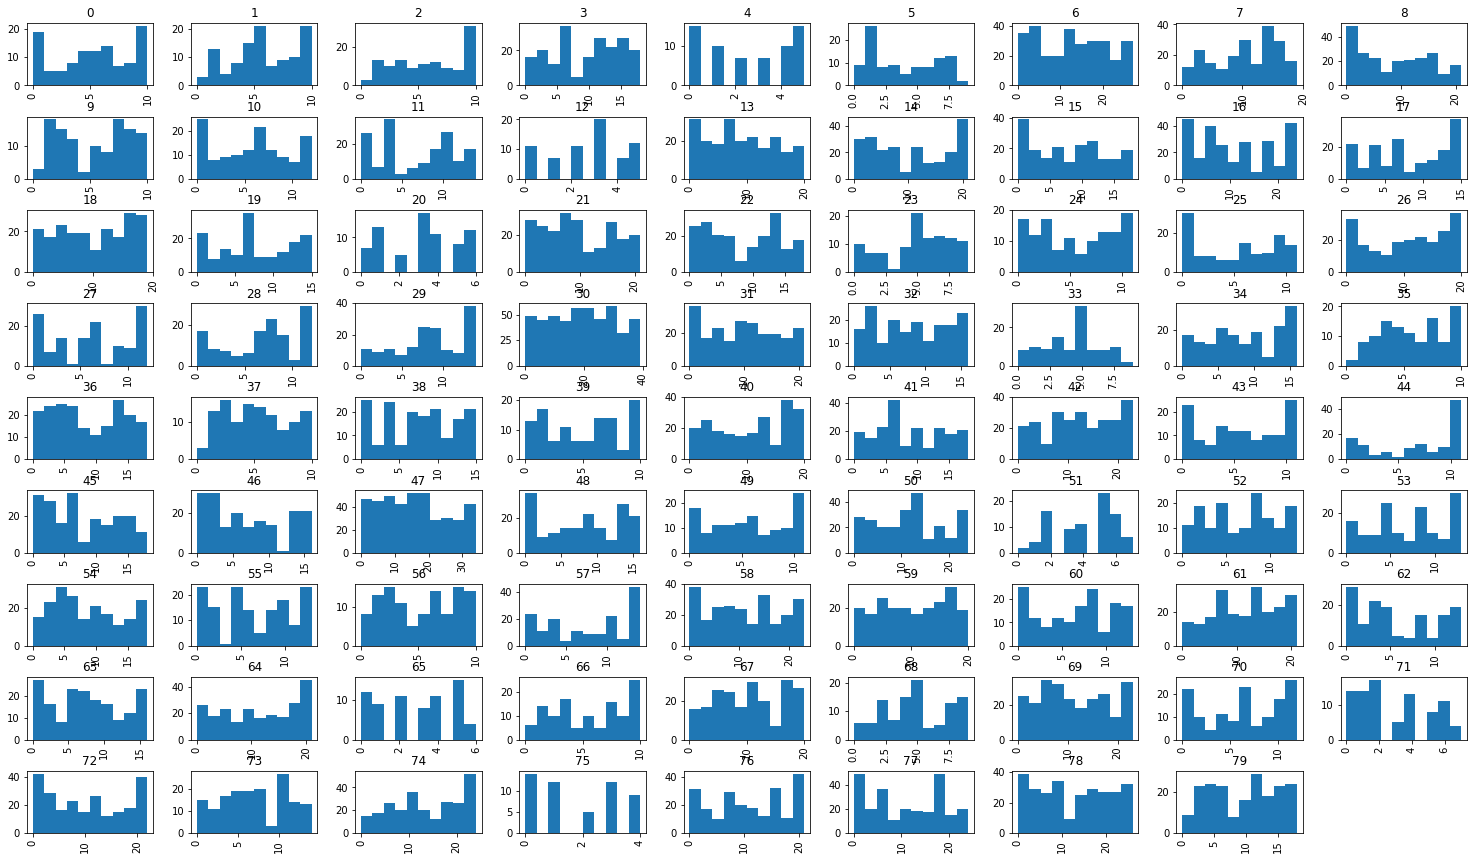

In [22]:
plt.rcParams['figure.figsize'] = [25, 15]
df.hist(column='secondary labels',by='labels')
plt.xlabel('second clustering')
plt.ylabel('count')

After looking at these visualizations it was apparent to me that the clusters were not all the same size and having 80 clusters, then even more additional clusters would make it confusing to try to actually pull the recommendations. 

Although I had tried so hard to try to find a clustering method that worked for me, including massaging KPrototypes a few times to make sure it was taking the categorical and numerical data correctly, I realized that KMeans would have done the trick without worrying about how KPrototypes was written, and so thus I set out to remedy my mistake by using KMeans clustering instead. 

# Building a Better Model! 

Instead of forcing data into KPrototypes, I decided to just go with naturally what came to mind when building recommenders, KMeans. When switching to KMeans, I could no longer use categorical data. What this required from me was to one hot encode all of my categorical data, which included the key, the mode, and the time signature.

In [3]:
#Getting the adjusted/normalized data set, dropping labels since that was our first cluster. 
df= pd.read_csv(r'C:\Users\Anna\Desktop\MSD_firstcluster.csv')
df=df.drop('labels',axis=1)
df.head()

,acousticness,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,Artist,Name
0,0.063000,0.751,0.073943,0.549,01TR6aAKrA2cI3Z0gnCOsu,0.000025,6,0.1060,0.740870,0.0,0.4290,0.374984,4,0.553,Casual,I Didn't Mean To
1,0.195000,0.749,0.049420,0.530,4yPl1mK1oluIrCwI4HInPR,0.000035,9,0.0748,0.697203,1.0,0.0326,0.493594,4,0.966,The Box Tops,Soul Deep
2,0.689000,0.699,0.061571,0.519,5JeyXbf7CrVQ8DqwFikN0P,0.000471,8,0.9350,0.814235,1.0,0.0290,0.416616,4,0.676,La Sonora Santanera,Amor de Cabaret (with Río Roma)
3,0.197000,0.596,0.078482,0.934,1BddSZ9x0Vi2WfZOSna47Z,0.007410,0,0.1840,0.861098,1.0,0.0459,0.488146,4,0.843,Adam Ant,Something Girls
4,0.000356,0.525,0.070727,0.918,4cdbM6efK43Cs2PDMtzdhv,0.566000,2,0.0904,0.848529,1.0,0.0543,0.527472,4,0.655,Gob,Face the Ashes


In [5]:
#concerting categorical variables to numbers by one hot encode
pd.get_dummies(data=df, columns=['key', 'mode','time_signature']);

In [6]:
df2 = pd.get_dummies(data=df, columns=['key', 'mode','time_signature']) 
df2.columns

Index(['acousticness', 'danceability', 'duration_ms', 'energy', 'id',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence', 'Artist', 'Name', 'key_0', 'key_1', 'key_2', 'key_3',
       'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10',
       'key_11', 'mode_0.0', 'mode_1.0', 'time_signature_0',
       'time_signature_1', 'time_signature_3', 'time_signature_4',
       'time_signature_5'],
      dtype='object')

In [8]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=1000,random_state=23,init='random')
df2['kmean_cluster']=km.fit_predict(df2[['acousticness','danceability','duration_ms','energy','instrumentalness','liveness','speechiness','tempo','valence','key_0', 'key_1', 'key_2', 'key_3', 'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10','key_11', 'mode_0.0', 'mode_1.0', 'time_signature_0','time_signature_1', 'time_signature_3', 'time_signature_4','time_signature_5']])

In [33]:
df2.head()

,acousticness,danceability,duration_ms,energy,id,instrumentalness,liveness,loudness,speechiness,tempo,...,key_10,key_11,mode_0.0,mode_1.0,time_signature_0,time_signature_1,time_signature_3,time_signature_4,time_signature_5,kmean_cluster
0,0.063000,0.751,0.073943,0.549,01TR6aAKrA2cI3Z0gnCOsu,0.000025,0.1060,0.740870,0.4290,0.374984,...,0,0,1,0,0,0,0,1,0,871
1,0.195000,0.749,0.049420,0.530,4yPl1mK1oluIrCwI4HInPR,0.000035,0.0748,0.697203,0.0326,0.493594,...,0,0,0,1,0,0,0,1,0,275
2,0.689000,0.699,0.061571,0.519,5JeyXbf7CrVQ8DqwFikN0P,0.000471,0.9350,0.814235,0.0290,0.416616,...,0,0,0,1,0,0,0,1,0,818
3,0.197000,0.596,0.078482,0.934,1BddSZ9x0Vi2WfZOSna47Z,0.007410,0.1840,0.861098,0.0459,0.488146,...,0,0,0,1,0,0,0,1,0,719
4,0.000356,0.525,0.070727,0.918,4cdbM6efK43Cs2PDMtzdhv,0.566000,0.0904,0.848529,0.0543,0.527472,...,0,0,0,1,0,0,0,1,0,385


In [10]:
df2['kmean_cluster'].value_counts().tail(20) 
#got the smaller clusters, as I would need to do something separate since they would not generate enough recommendations

812    2
909    2
109    2
90     2
352    2
849    2
763    2
928    2
373    2
721    2
67     2
55     1
308    1
297    1
569    1
591    1
596    1
609    1
643    1
666    1
Name: kmean_cluster, dtype: int64

In [37]:
km.inertia_ #inertia of the entire cluster shows the approximate summed distance between all of the cluster centroids

1469.051168722175

In [54]:
X=df2[['acousticness','danceability','duration_ms','energy','instrumentalness','liveness','speechiness','tempo','valence','key_0', 'key_1', 'key_2', 'key_3', 'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10','key_11', 'mode_0.0', 'mode_1.0', 'time_signature_0','time_signature_1', 'time_signature_3', 'time_signature_4','time_signature_5']]

In [55]:
import sklearn.metrics as metrics
labels = km.labels_
metrics.calinski_harabaz_score(X, labels) 

235.38356379979714

As you can see this is a relatively low inertia value compared to the several thousand of kprototypes, which means all songs should be generally well clustered around their cluster centers, meaning that the groups of songs around each cluster center should be similar enough in the categories that I had filtered for in the clustering. 

In [35]:
df2.to_csv(r'C:\Users\Anna\Desktop\MSDkmeans.csv',index=False)

In [36]:
df2['kmean_cluster'].value_counts().describe()

count    1000.000000
mean       13.908000
std         7.460777
min         1.000000
25%         9.000000
50%        13.000000
75%        18.000000
max        42.000000
Name: kmean_cluster, dtype: float64

So I could see here that the mean cluster size was around 14, but the standard deviation was quite high and there were clusters as small as 1. Only having one song in a cluster would not generate a good recommendation system so what I decided to do for smaller clusters was generate pair wise differences by hand and pick the 5 closest songs and use those as recommendations. 

In [3]:
df=pd.read_csv(r'C:\Users\Anna\Desktop\MSDkmeans.csv')

In [4]:
#This is finding which clusters had not enough songs, and grouping them together for safe keeping while we get all the songs 
vc = df['kmean_cluster'].value_counts()
toosmall=vc[vc<5].index
print(toosmall)
len(toosmall)

Int64Index([334, 278, 494, 202, 546, 293,  59, 650, 962, 996,  79, 732, 779,
            795, 444, 832, 499, 709, 752,  76, 411, 495, 537, 539, 388, 549,
            135,   1, 869, 428, 731, 466, 244, 981, 422, 635, 201, 919, 289,
            361, 885, 975, 939, 300, 325,  58, 868, 619, 150,  46,  34, 688,
            511,  82, 660, 679, 496, 812, 909, 109,  90, 352, 849, 763, 928,
            373, 721,  67,  55, 308, 297, 569, 591, 596, 609, 643, 666],
           dtype='int64')


77

In [5]:
small = df.loc[df['kmean_cluster'].isin(toosmall)] #getting the clusters that were too small 
master = df[df.columns.difference(['id','Name','Artist','kmean_cluster'])]
#getting rid of the columns that would affect pair difference

In [6]:
songs = list(small.index)
print(songs)
# This is the list of songs that are in the clusters with less than 4 other songs that could be recommended to

[43, 44, 61, 72, 181, 232, 270, 308, 315, 463, 529, 551, 587, 604, 640, 680, 692, 861, 884, 899, 911, 968, 985, 991, 1010, 1078, 1095, 1116, 1117, 1285, 1287, 1304, 1358, 1377, 1378, 1472, 1566, 1603, 1638, 1690, 1792, 1850, 1959, 1960, 2035, 2140, 2178, 2290, 2357, 2362, 2370, 2527, 2531, 2562, 2564, 2578, 2594, 2624, 2686, 2799, 2813, 2842, 2881, 2895, 3153, 3185, 3193, 3210, 3335, 3403, 3464, 3507, 3631, 3683, 3717, 3742, 3826, 3990, 4089, 4097, 4227, 4324, 4400, 4421, 4483, 4638, 4731, 4746, 4849, 4909, 5023, 5084, 5320, 5382, 5409, 5434, 5462, 5785, 5939, 5950, 6117, 6237, 6264, 6286, 6322, 6329, 6338, 6634, 6646, 6689, 6761, 6801, 6856, 6917, 6927, 6964, 7309, 7313, 7368, 7387, 7413, 7425, 7452, 7528, 7579, 7668, 7691, 7791, 7868, 8155, 8185, 8214, 8296, 8303, 8579, 8689, 8733, 8804, 8852, 8868, 8886, 8981, 9006, 9102, 9107, 9123, 9220, 9324, 9413, 9416, 9479, 9526, 9562, 9566, 9710, 9749, 9768, 9773, 9857, 9898, 9992, 10006, 10128, 10205, 10237, 10279, 10328, 10354, 10398, 10416

In [7]:
#building the pair distance dataframe by calculating difference between referenced song and all other songs
from scipy.spatial import distance
newdf = pd.DataFrame()
for each in songs:
    start_time = time.time()
    distances = []
    for row in range(len(master)):
        distances.append(distance.euclidean(master.loc[each],master.iloc[row]))
    newdf[each]=distances
    end_time = time.time()
print(newdf.head())

      43        44        61        72        181       232       270    \
0  2.167174  2.115918  2.251973  2.364924  2.648891  2.462953  2.067588   
1  1.759433  1.484175  1.805070  1.543547  2.148891  2.014867  1.524730   
2  0.992017  1.659095  1.502826  1.858187  2.344665  1.990346  1.664950   
3  1.686271  1.428271  1.766870  1.900844  2.196067  2.093080  1.451237   
4  1.794090  1.584084  1.236853  1.952257  2.131165  1.956229  1.577851   

      308       315       463      ...        13540     13596     13618  \
0  2.263940  2.134781  2.378889    ...     1.924593  2.202226  1.862825   
1  1.980158  1.466540  2.136700    ...     2.433695  1.616666  2.791713   
2  1.790125  1.834116  1.844469    ...     2.450050  1.504538  2.906229   
3  1.990072  1.542504  2.031524    ...     2.505267  0.726872  2.731019   
4  1.556327  1.652263  2.137138    ...     2.516201  1.759129  2.541274   

      13648     13682     13690     13718     13842     13878     13899  
0  2.401160  1.749170  2

In [9]:
reco=[]
names=[]
for each in songs:
    name = df.loc[each,'Name']
    names.append(name)
    relate = list(newdf[each].sort_values()[1:6].index)#grabbed lowest 5 songs of distance not including itself 
    rec=[]
    for i in relate:
        ff=df.loc[i,['Artist','Name']].tolist()
        ff2 = ["Artist: " + ff[0],"Name: "+ff[1]] #added each song of the lowest 5 into a list to return
        rec.append(ff2)
    reco.append(rec)

In [10]:
smallcheck = pd.DataFrame(
    {'NameSong': names,
     'Recommendations': reco
    })

In [11]:
import random

# Recommendation System In Action


In [22]:
a = input()
if any(a in word for word in names): #checking in dataframe of premade recommendations
    recommend = smallcheck.loc[smallcheck['NameSong']==a]['Recommendations']
    group = recommend.index.item()
    print(newdf.iloc[group].mean())
    for values in recommend:
        for each in values:
            print(", ".join(each))
else:
    cluster = df.loc[df['Name']==a]['kmean_cluster'].values #cluster number
    cluster = random.choice(cluster) #if more than one cluster was returned due to same song name, pick one
    parser= list(df.loc[df['kmean_cluster']==cluster].index) #get a list of indexes where the cluster number is shared
    numberselect= 5
    random_index= random.sample(parser,5) #get 5 random indexes from the list where they are shared
    print(random_index)
    for each in random_index:
        recsong= df.iloc[each]['Name']
        recart= df.iloc[each]['Artist']
        print('Artist: ' + recart + ', Name: '+ recsong) #prints the recommendation
        print('Pairwise distance to Original Song: '+ str(distance.euclidean(master.loc[df['Name']==a],master.loc[each]))) #print pairwise distance of the song

Yoda
2.0461511117183937
Artist: Helen Love, Name: So Hot
Artist: Nichole Nordeman, Name: Do You Hear What I Hear
Artist: Die Fantastischen Vier, Name: Was wollen wir noch mehr?
Artist: David Cassidy, Name: Darlin'
Artist: Warrior King, Name: Breath Of Fresh Air


In [24]:
a = input()
if any(a in word for word in names): #checking in dataframe of premade recommendations
    recommend = smallcheck.loc[smallcheck['NameSong']==a]['Recommendations']
    group = recommend.index.item()
    print(newdf.iloc[group].mean())
    for values in recommend:
        for each in values:
            print(", ".join(each))
else:
    cluster = df.loc[df['Name']==a]['kmean_cluster'].values #cluster number
    cluster = random.choice(cluster)
    parser= list(df.loc[df['kmean_cluster']==cluster].index)
    numberselect= 5
    random_index= random.sample(parser,5)
    for each in random_index:
        recsong= df.iloc[each]['Name']
        recart= df.iloc[each]['Artist']
        print('Artist: ' + recart + ', Name: '+ recsong)
        print('Pairwise distance to Original Song: '+ str(distance.euclidean(master.loc[df['Name']==a],master.loc[each])))

High Tide
Artist: Cargo Cult, Name: Helium
Pairwise distance to Original Song: 0.41652199498929665
Artist: Richard Souther, Name: High Tide
Pairwise distance to Original Song: 0.0
Artist: Jessy, Name: Look at me now - E-Ject Remix
Pairwise distance to Original Song: 0.44321234759199857
Artist: True Lies, Name: Valeries Biography
Pairwise distance to Original Song: 0.5012196075475738
Artist: Fleet Foxes, Name: English House
Pairwise distance to Original Song: 0.35648386100183177


In [25]:
a = input()
if any(a in word for word in names): #checking in dataframe of premade recommendations
    recommend = smallcheck.loc[smallcheck['NameSong']==a]['Recommendations']
    group = recommend.index.item()
    print(newdf.iloc[group].mean())
    for values in recommend:
        for each in values:
            print(", ".join(each))
else:
    cluster = df.loc[df['Name']==a]['kmean_cluster'].values #cluster number
    cluster = random.choice(cluster)
    parser= list(df.loc[df['kmean_cluster']==cluster].index)
    numberselect= 5
    random_index= random.sample(parser,5)
    for each in random_index:
        recsong= df.iloc[each]['Name']
        recart= df.iloc[each]['Artist']
        print('Artist: ' + recart + ', Name: '+ recsong)
        print('Pairwise distance to Original Song: '+ str(distance.euclidean(master.loc[df['Name']==a],master.loc[each])))

Biding Her Time
Artist: Jim Reeves, Name: I Guess I'm Crazy
Pairwise distance to Original Song: 0.5146289653364899
Artist: Tex Williams, Name: Start Even
Pairwise distance to Original Song: 0.3603012086067515
Artist: Angelo Badalamenti, Name: Overture/Blue Tahitian Moon
Pairwise distance to Original Song: 0.8172226525209572
Artist: Mickey Gilley, Name: World Of Our Own
Pairwise distance to Original Song: 0.4220466488848639
Artist: We Show Up On Radar, Name: Like a Bird Pulling Up At a Worm
Pairwise distance to Original Song: 0.5999379860430777


In [26]:
a = input()
if any(a in word for word in names): #checking in dataframe of premade recommendations
    recommend = smallcheck.loc[smallcheck['NameSong']==a]['Recommendations']
    group = recommend.index.item()
    print(newdf.iloc[group].mean())
    for values in recommend:
        for each in values:
            print(", ".join(each))
else:
    cluster = df.loc[df['Name']==a]['kmean_cluster'].values #cluster number
    cluster = random.choice(cluster)
    parser= list(df.loc[df['kmean_cluster']==cluster].index)
    numberselect= 5
    random_index= random.sample(parser,5)
    for each in random_index:
        recsong= df.iloc[each]['Name']
        recart= df.iloc[each]['Artist']
        print('Artist: ' + recart + ', Name: '+ recsong)
        print('Pairwise distance to Original Song: '+ str(distance.euclidean(master.loc[df['Name']==a],master.loc[each])))

Jenny Take A Ride
Artist: Nomadi, Name: Il Libero
Pairwise distance to Original Song: 0.2711806175666563
Artist: The Legendary Stardust Cowboy, Name: I Hate CD's
Pairwise distance to Original Song: 0.32331488884275167
Artist: The Bonzo Dog Band, Name: The Strain - 2007 Remastered Version
Pairwise distance to Original Song: 0.25373318578722237
Artist: Reni, Name: Nema dana ni meseca
Pairwise distance to Original Song: 0.227544776518119
Artist: Sheila Walsh, Name: Circle Of Hands - For A Time Like This Album Version
Pairwise distance to Original Song: 0.21162946887254883
